In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
%matplotlib inline

In [2]:
for gpu in tf.config.experimental.list_physical_devices("GUP"):
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
img_path = glob.glob("d:/datasets/birds/*/*.jpg")*10 #做数据增强

In [4]:
len(img_path)#查看数据集是否读取成功

1600

In [5]:
img_path[:5],img_path[-5:]

(['d:/datasets/birds\\005.Crested_Auklet\\0.jpg',
  'd:/datasets/birds\\005.Crested_Auklet\\1.jpg',
  'd:/datasets/birds\\005.Crested_Auklet\\10.jpg',
  'd:/datasets/birds\\005.Crested_Auklet\\11.jpg',
  'd:/datasets/birds\\005.Crested_Auklet\\12.jpg'],
 ['d:/datasets/birds\\008.Rhinoceros_Auklet\\5.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\6.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\7.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\8.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\9.jpg'])

In [6]:
import random
random.shuffle(img_path)#打乱数据集

In [8]:
img_path[:5],img_path[-5:]

(['d:/datasets/birds\\008.Rhinoceros_Auklet\\11.jpg',
  'd:/datasets/birds\\006.Least_Auklet\\33.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\39.jpg',
  'd:/datasets/birds\\007.Parakeet_Auklet\\36.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\22.jpg'],
 ['d:/datasets/birds\\007.Parakeet_Auklet\\2.jpg',
  'd:/datasets/birds\\005.Crested_Auklet\\3.jpg',
  'd:/datasets/birds\\007.Parakeet_Auklet\\37.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\33.jpg',
  'd:/datasets/birds\\007.Parakeet_Auklet\\8.jpg'])

In [9]:
#定义一个字典存储标签和鸟类的名字
dic_l_name = {0:"Crested_Auklet",1:"Least_Auklet",2:"Parakeet_Auklet",3:"Rhinoceros_Auklet"}

In [10]:
# 把dic_l_name这个字典的键和值对调
dic_n_l = dict(zip(dic_l_name.values(),dic_l_name.keys()))
dic_n_l

{'Crested_Auklet': 0,
 'Least_Auklet': 1,
 'Parakeet_Auklet': 2,
 'Rhinoceros_Auklet': 3}

In [12]:
# 将所有的标签取出来
all_image_labels = [dic_n_l.get(p.split(".")[1].split("\\")[0]) for p in img_path]

In [14]:
all_image_labels[:10]

[3, 1, 3, 2, 3, 0, 1, 3, 0, 0]

In [17]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])
    image = tf.image.random_crop(image,[256,256,3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_contrast(image,0,1)
    image = tf.image.random_brightness(image,0.5)
    image = tf.cast(image,tf.float32)
    image = image/255.0
    return image

598 Parakeet_Auklet


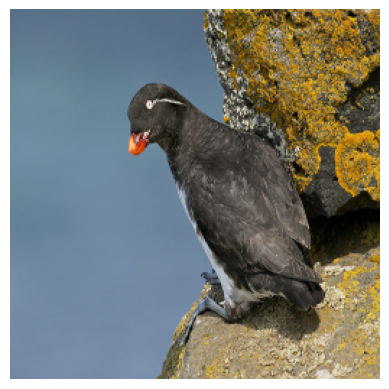

In [19]:
rr = random.randint(0,len(img_path))
img_path_ = img_path[rr]
plt.imshow(load_and_preprocess_image(img_path_))
plt.axis("off")
print(rr,dic_l_name.get(all_image_labels[rr]))

# print(rr,dic_l_name.get(all_image_labels[rr]))

In [21]:
path_ds = tf.data.Dataset.from_tensor_slices(img_path[:int(len(img_path)*.85)])
test_ds = tf.data.Dataset.from_tensor_slices(img_path[int(len(img_path)*.85):])

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

In [31]:
test_image_ds = test_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

In [32]:
label_ds = tf.data.Dataset.from_tensor_slices(
    tf.cast(all_image_labels[:int(len(img_path)*.85)],tf.int64))
test_label_ds = all_image_labels[int(len(img_path)*.85):]

In [33]:
image_label_ds = tf.data.Dataset.zip((image_ds,label_ds))

In [34]:
train_count = (int(len(img_path)*.85))

In [35]:
train_data = image_label_ds

In [36]:
BATCH_SIZE = 32

In [37]:
train_data = train_data.repeat()
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(BATCH_SIZE)

In [38]:
test_image_ds = test_image_ds.batch(BATCH_SIZE)

# 建立模型

In [39]:
model = tf.keras.Sequential() #顺序模型
model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'))#卷积层
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64,activation='relu'))#全连接层
model.add(tf.keras.layers.Dense(4,activation='softmax'))#全连接层

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 64)     256       
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6,468
Trainable params: 6,340
Non-trainabl

In [41]:
# 设置优化器
model.compile(optimizer='adam',
             loss=tf.losses.sparse_categorical_crossentropy,
             metrics=['acc'])

In [43]:
steps_per_epoch = train_count//BATCH_SIZE

In [57]:
# 训练模型
history = model.fit(train_data,epochs=20,steps_per_epoch=steps_per_epoch)

Epoch 1/20
42/42 [==============================] - 49s 1s/step - loss: 1.0584 - acc: 0.5246
Epoch 2/20
42/42 [==============================] - 48s 1s/step - loss: 1.0233 - acc: 0.5618
Epoch 3/20
42/42 [==============================] - 47s 1s/step - loss: 1.0034 - acc: 0.5647
Epoch 4/20
42/42 [==============================] - 47s 1s/step - loss: 0.9700 - acc: 0.5796
Epoch 5/20
42/42 [==============================] - 47s 1s/step - loss: 0.9560 - acc: 0.5804
Epoch 6/20
42/42 [==============================] - 48s 1s/step - loss: 0.9236 - acc: 0.6064
Epoch 7/20
42/42 [==============================] - 47s 1s/step - loss: 0.9185 - acc: 0.5900
Epoch 8/20
42/42 [==============================] - 47s 1s/step - loss: 0.8861 - acc: 0.6198
Epoch 9/20
42/42 [==============================] - 47s 1s/step - loss: 0.8722 - acc: 0.6138
Epoch 10/20
42/42 [==============================] - 47s 1s/step - loss: 0.8525 - acc: 0.6406
Epoch 11/20
42/42 [==============================] - 47s 1s/step - lo

In [58]:
history.history.keys()

dict_keys(['loss', 'acc'])

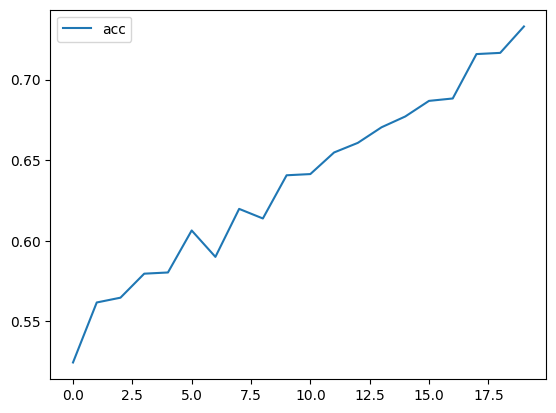

In [59]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.legend()

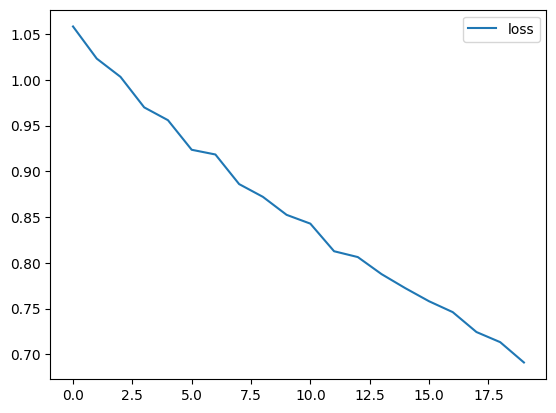

In [60]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.legend()

In [61]:
pred = model.predict(test_image_ds)

8/8 [==============================] - 2s 263ms/step


In [62]:
pred

array([[8.51017714e-04, 1.45668001e-03, 6.35923527e-04, 9.97056365e-01],
       [2.82974690e-01, 1.98265329e-01, 1.44996554e-01, 3.73763472e-01],
       [1.16494395e-01, 6.00103140e-01, 2.46429116e-01, 3.69733609e-02],
       [2.50687331e-01, 2.70699143e-01, 3.42712641e-01, 1.35900915e-01],
       [1.43982023e-02, 3.91984731e-02, 7.11914241e-01, 2.34489128e-01],
       [2.92468555e-02, 7.33661950e-02, 4.37105983e-01, 4.60280985e-01],
       [3.90455455e-01, 6.81727603e-02, 1.60695836e-02, 5.25302231e-01],
       [6.12079259e-03, 7.16314554e-01, 2.12787539e-02, 2.56285876e-01],
       [6.15132093e-01, 2.00205028e-01, 1.35508338e-02, 1.71112001e-01],
       [6.12777174e-01, 9.57623422e-02, 2.87531555e-01, 3.92891979e-03],
       [5.85193001e-02, 4.96110059e-02, 8.69294345e-01, 2.25753468e-02],
       [4.15631652e-01, 3.94094080e-01, 7.05465600e-02, 1.19727716e-01],
       [4.55306977e-01, 5.39748631e-02, 7.31022592e-05, 4.90645021e-01],
       [1.81364030e-01, 4.92616057e-01, 4.97425646e

In [63]:
pred_ = np.argmax(pred,axis=1)

In [64]:
pred_

array([3, 3, 1, 2, 2, 3, 3, 1, 0, 0, 2, 0, 3, 1, 2, 3, 3, 3, 2, 2, 0, 3,
       3, 3, 0, 3, 3, 2, 2, 3, 2, 3, 3, 2, 1, 3, 3, 2, 1, 2, 2, 1, 0, 2,
       1, 3, 3, 3, 3, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0, 3, 2, 0, 0, 3, 2,
       0, 2, 2, 2, 1, 0, 2, 2, 1, 3, 2, 2, 2, 2, 3, 3, 2, 0, 2, 2, 2, 3,
       2, 3, 0, 0, 2, 3, 2, 1, 3, 1, 2, 3, 2, 0, 0, 2, 1, 3, 1, 1, 3, 2,
       3, 2, 3, 2, 2, 3, 0, 2, 2, 0, 2, 1, 2, 2, 3, 1, 3, 2, 0, 3, 3, 2,
       3, 3, 2, 2, 3, 2, 2, 3, 0, 3, 3, 2, 1, 2, 3, 0, 2, 3, 2, 2, 2, 0,
       1, 2, 3, 2, 2, 2, 2, 1, 3, 2, 2, 2, 0, 2, 2, 2, 0, 3, 2, 2, 3, 2,
       1, 2, 2, 2, 3, 3, 3, 0, 3, 3, 2, 2, 3, 2, 3, 1, 1, 3, 1, 1, 3, 2,
       3, 1, 3, 1, 0, 2, 3, 3, 0, 1, 3, 2, 2, 3, 2, 1, 3, 0, 0, 1, 0, 0,
       0, 3, 3, 2, 1, 0, 0, 2, 1, 0, 3, 3, 1, 0, 3, 2, 2, 2, 3, 2],
      dtype=int64)

In [65]:
from sklearn.metrics import classification_report

In [66]:
print(classification_report(test_label_ds,pred_))

              precision    recall  f1-score   support

           0       0.76      0.45      0.57        62
           1       0.82      0.47      0.60        59
           2       0.63      1.00      0.77        59
           3       0.69      0.87      0.77        60

    accuracy                           0.70       240
   macro avg       0.73      0.70      0.68       240
weighted avg       0.73      0.70      0.68       240

